# Project Goal

The project compares how well different models can predict Tesla's price using data from January 2023 to January 2024. It will test ARIMA, AutoARIMA and LSTM models, using Tesla's price alone and also including other factors like the QQQ index, VIX, and GDP.


# Install and Prepare data

## Install data

In [348]:
# prompt: clear all environment to reset the whole page

import os

# Clear output
from IPython.display import clear_output
clear_output()

# Reset variables (this might not be completely exhaustive)
%reset -f


In [349]:
# Installing packages

!pip install yfinance pandas numpy statsmodels matplotlib
!pip install fredapi
!pip install pmdarima
!pip install statsforecast
!pip install dask[dataframe]

## Load and fetch data from online resoures

In [350]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pylab import rcParams
from matplotlib import pyplot
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
import yfinance as yf
import pandas as pd
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

# Define plot style for the project

In [351]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

## Prepare data

### Fetching data


In [352]:
# Fetch stock data
tesla = yf.download("TSLA", start="2023-01-01", end="2024-01-01")[["Close"]]
vix = yf.download("^VIX", start="2023-01-01", end="2024-01-01")[["Close"]]
qqq = yf.download("QQQ", start="2023-01-01", end="2024-01-01")[["Close"]]

# Initialize FRED API
fred = Fred(api_key="28018d6e3b62136898c8ac3cadd18686")

# Fetch GDP data from FRED (Quarterly)
gdp_data = fred.get_series('GDP', frequency='q')

# Convert the series to a DataFrame
gdp_df = pd.DataFrame(gdp_data, columns=['GDP'])

# Convert GDP index to datetime format and resample to daily frequency
gdp_df.index = pd.to_datetime(gdp_df.index)  # Ensure datetime index
gdp_df = gdp_df.asfreq('D').ffill()  # Resample to daily and forward-fill

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Viewing data

In [353]:
# Display rows and columns
display(tesla.head())
display(vix.head())
display(qqq.head())
display(gdp_df.head())

Price,Close
Ticker,TSLA
Date,
2023-01-03,108.099998
2023-01-04,113.639999
2023-01-05,110.339996
2023-01-06,113.059998
2023-01-09,119.769997


Price,Close
Ticker,^VIX
Date,
2023-01-03,22.900000
2023-01-04,22.010000
2023-01-05,22.459999
2023-01-06,21.129999
2023-01-09,21.969999


Price,Close
Ticker,QQQ
Date,
2023-01-03,261.113495
2023-01-04,262.357422
2023-01-05,258.250397
2023-01-06,265.378510
2023-01-09,267.096344


,GDP
1946-01-01,NaN
1946-01-02,NaN
1946-01-03,NaN
1946-01-04,NaN
1946-01-05,NaN


### Data overview

In [354]:
print(tesla.info())
print(vix.info())
print(qqq.info())
print(gdp_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 to 2023-12-29
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, TSLA)  250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 to 2023-12-29
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, ^VIX)  250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 to 2023-12-29
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (Close, QQQ)  250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28764 entries, 1946-01-01 to 2024-10-01
Freq: D
Da

# Univariate Time Series Forecasting (ARIMA model using only past price data)



## Plotting Tesla for an overview

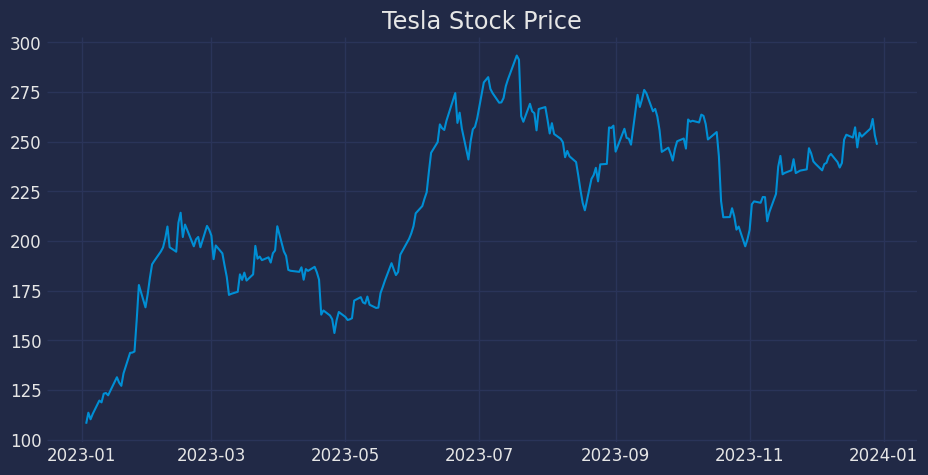

In [355]:
# Plotting tesla
plt.figure(figsize=(10, 5))
plt.plot(tesla, label="Tesla Price")
plt.title("Tesla Stock Price")
plt.show()

## Transform data

In [356]:
# Make a copy of Tesla dataframe
tesla_1 = tesla.copy()

if isinstance(tesla_1.columns, pd.MultiIndex):
    tesla_1.columns = ['_'.join(col).strip() for col in tesla_1.columns.values]


print(tesla_1.head())

            Close_TSLA
Date                  
2023-01-03  108.099998
2023-01-04  113.639999
2023-01-05  110.339996
2023-01-06  113.059998
2023-01-09  119.769997


## AutoArima model

### Prepping the DataFrame to run AutoARIMA

In [357]:
tesla_1 = tesla_1.reset_index()
tesla_1['unique_id'] = "1"
tesla_1 = tesla_1.rename(columns={"Date": "ds", "Close_TSLA": "y"})
print(tesla_1.head())
print(tesla_1.info())

          ds           y unique_id
0 2023-01-03  108.099998         1
1 2023-01-04  113.639999         1
2 2023-01-05  110.339996         1
3 2023-01-06  113.059998         1
4 2023-01-09  119.769997         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         250 non-null    datetime64[ns]
 1   y          250 non-null    float64       
 2   unique_id  250 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.0+ KB
None


In [358]:
# Convert ds to date time
tesla_1["ds"] = pd.to_datetime(tesla_1["ds"])
#tesla_1 = tesla_1.asfreq('B')
print(tesla_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         250 non-null    datetime64[ns]
 1   y          250 non-null    float64       
 2   unique_id  250 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.0+ KB
None


### Autocorrelation plots

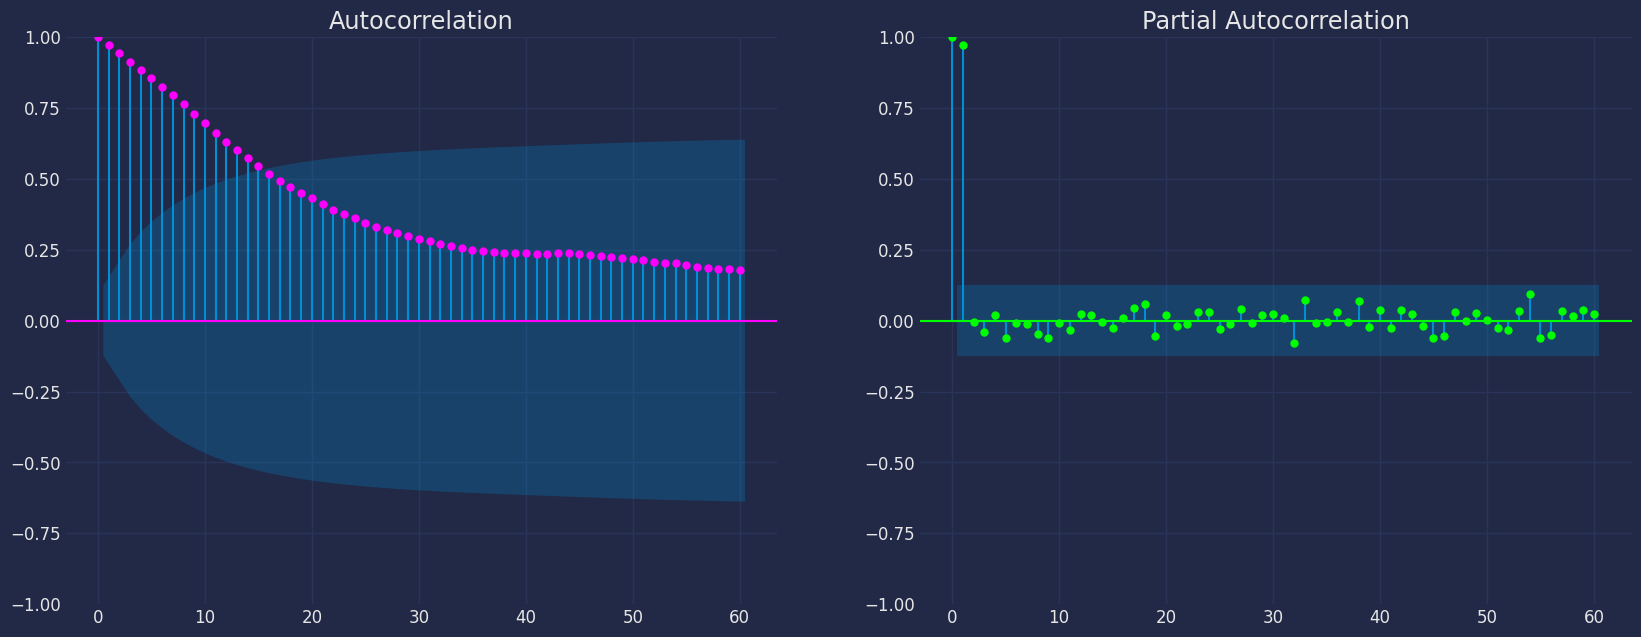

In [359]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(tesla_1["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(tesla_1["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

For ACF Plot

- Strong positive autocorrelation at lag 1 → This indicates trend in the data.
- Slow, gradual decline → Suggests non-stationarity (trend remains over time).
- Significant autocorrelations beyond lag 1 → Indicates strong dependencies between past values.
- Many lags outside the confidence interval (blue region) → Further confirms non-stationarity.

For PACF Plot
- Sharp cutoff after lag 1 → Indicates an AR(1) process.
No significant spikes beyond lag 1 → Suggests that a low p value (e.g., p=1) is appropriate.
- Values beyond lag 1 are within the confidence interval → Reinforces that p=1 might be sufficien

Conclusion:
- These plots suggest the starting point for (p,d,q) could be (1,1,0)

### Decomposing the Data

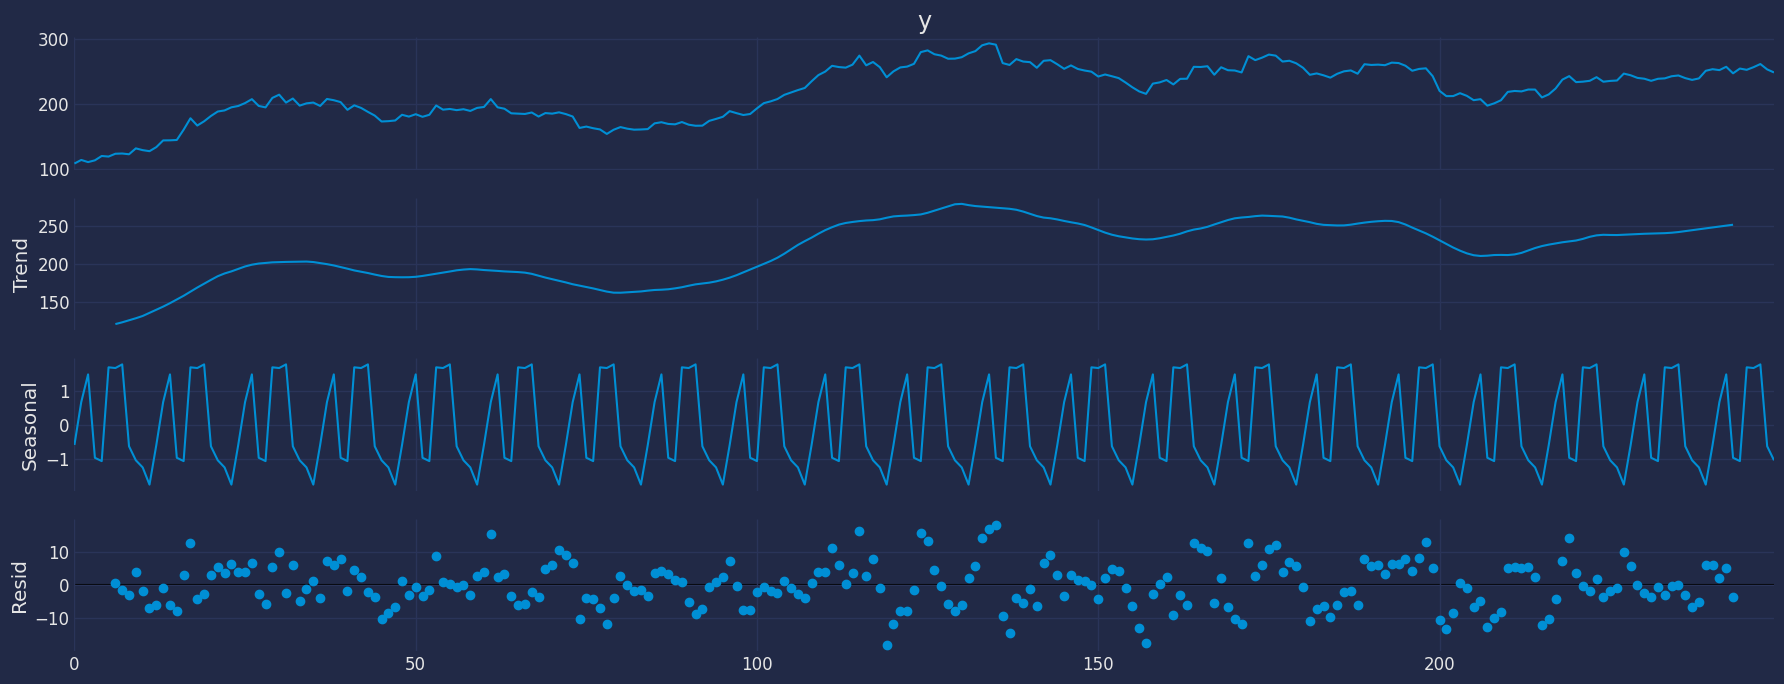

In [360]:
# Additive Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(tesla_1["y"], model = "add", period=12)
a.plot();

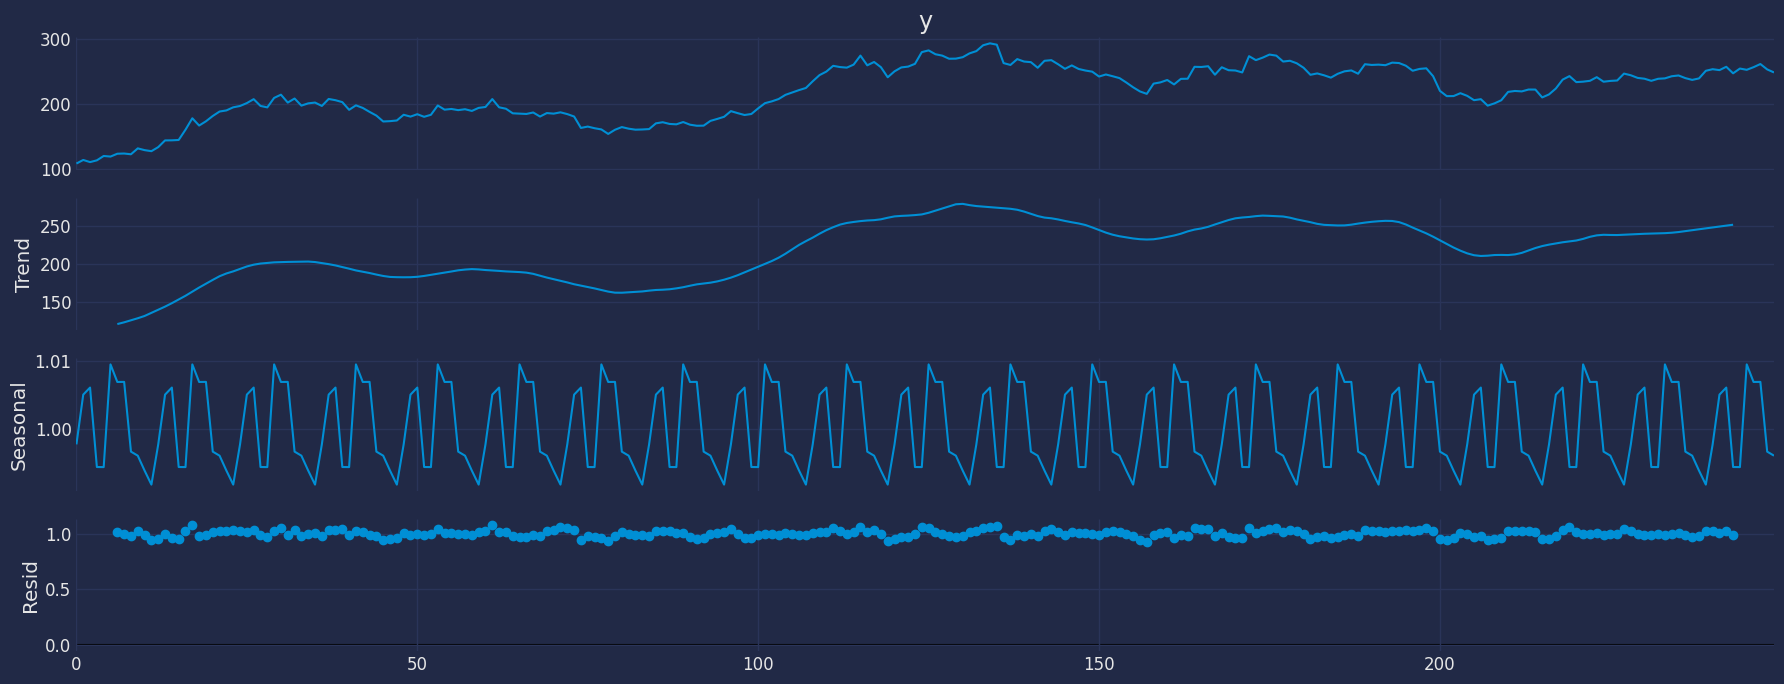

In [361]:
# A Multiplicative Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(tesla_1["y"], model = "mult", period=12)
a.plot();

Obervation:
- The data has an upward trend and is not stationary.
- The stock price exhibits a long-term upward trend with intermediate fluctuations.
- The data contains a strong seasonal component—the stock price moves in a cyclic pattern.
- Since the seasonality remains constant over time in the additive model, the data is best represented by an additive time series.

Conclusion:
- Will need to test for seasonality to consider using Seasonal ARIMA.
- The data is best represented by an additive time series.

### Test if Seasonality is real

In [362]:
# Extract the seasonal component
seasonal_component = a.seasonal

# ADF Test on Seasonal Component
result = adfuller(seasonal_component)  # Extracted from decomposition
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("Seasonality is real and significant.")
    print("Consider using SARIMA")
else:
    print(" No strong seasonality, likely an artifact.")


ADF Statistic: -1215516060054249.8
p-value: 0.0
Seasonality is real and significant.
Consider using SARIMA


### Running AutoARIMA

#### Split the data into Train and Test Sets

In [363]:
train_size = int(len(tesla_1) * 0.8)
Y_train_df, Y_test_df = tesla_1.iloc[:train_size], tesla_1.iloc[train_size:]
print(Y_train_df.shape, Y_test_df.shape)

(200, 3) (50, 3)


#### Defining the model

In [364]:
horizon = len(Y_test_df) # number of predictions
season_length = 12 # Monthly data
models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(models=models, freq='MS')

#### Fitting the model

In [365]:
sf.fit(df=Y_train_df)
StatsForecast(models=[AutoARIMA], freq='MS')

StatsForecast(models=[<class 'statsforecast.models.AutoARIMA'>])

#### Outputting the Optimal Parameters

In [366]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(0,1,0)                   '

ARIMA(0,1,0) is equivalent to a Random Walk Model:

- The best forecast for tomorrow's price is today’s price.
- No additional patterns (such as autoregression or moving averages) were found.

#### Forecasting

In [367]:
# Forecasting using the model
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon, fitted=True)
Y_hat_df.head()

,unique_id,ds,AutoARIMA
0,1,2023-11-01,242.679993
1,1,2023-12-01,242.679993
2,1,2024-01-01,242.679993
3,1,2024-02-01,242.679993
4,1,2024-03-01,242.679993


In [368]:
# Fittinng forecast with past values
values=sf.forecast_fitted_values()
values

,unique_id,ds,y,AutoARIMA
0,1,2023-01-03,108.099998,107.991899
1,1,2023-01-04,113.639999,108.099998
2,1,2023-01-05,110.339996,113.639999
3,1,2023-01-06,113.059998,110.339996
4,1,2023-01-09,119.769997,113.059998
...,...,...,...,...
195,1,2023-10-12,258.869995,262.989990
196,1,2023-10-13,251.119995,258.869995
197,1,2023-10-16,253.919998,251.119995
198,1,2023-10-17,254.850006,253.919998


In [369]:
# Include 95% CI
sf.forecast(df=Y_train_df, h=12, level=[95])

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,1,2023-11-01,242.679993,228.671544,256.688442
1,1,2023-12-01,242.679993,222.869054,262.490931
2,1,2024-01-01,242.679993,218.416647,266.943338
3,1,2024-02-01,242.679993,214.663094,270.696891
4,1,2024-03-01,242.679993,211.356148,274.003837
5,1,2024-04-01,242.679993,208.366440,276.993545
6,1,2024-05-01,242.679993,205.617120,279.742865
7,1,2024-06-01,242.679993,203.058115,282.301870
8,1,2024-07-01,242.679993,200.654645,284.705340
9,1,2024-08-01,242.679993,198.381387,286.978598


Auto-ARIMA forecast is constant (242.6799 for all future dates), which suggests that the model might not capture trends or seasonality correctly.

#### Plotting

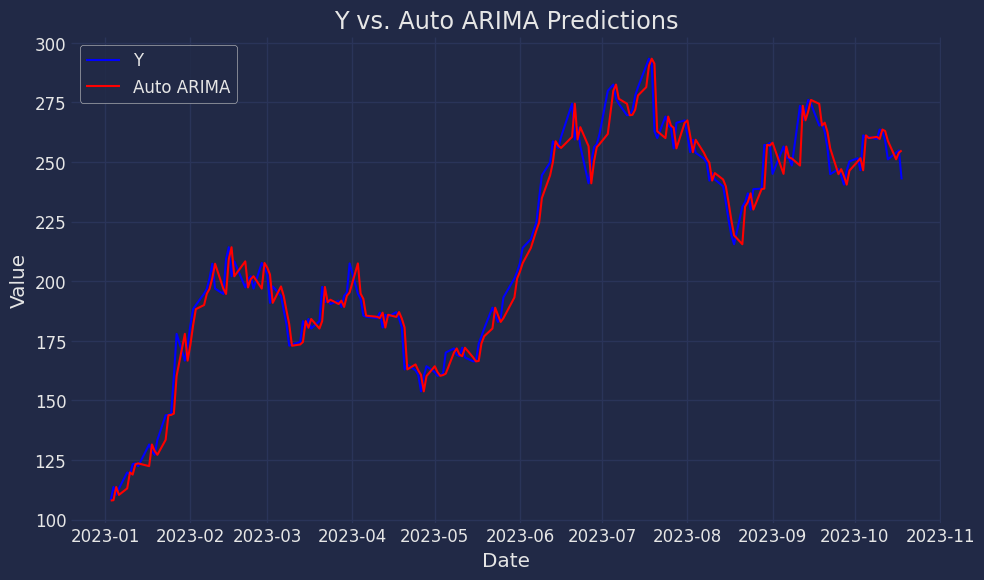

In [370]:
# Plot Y value and Autoarima forecast on past price
plt.figure(figsize=(10, 6))
plt.plot(values['ds'], values['y'], label='Y', color='blue')
plt.plot(values['ds'], values['AutoARIMA'], label='Auto ARIMA', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Y vs. Auto ARIMA Predictions')
plt.legend()
plt.grid(True)
plt.show()


The model did great on forecasting past value


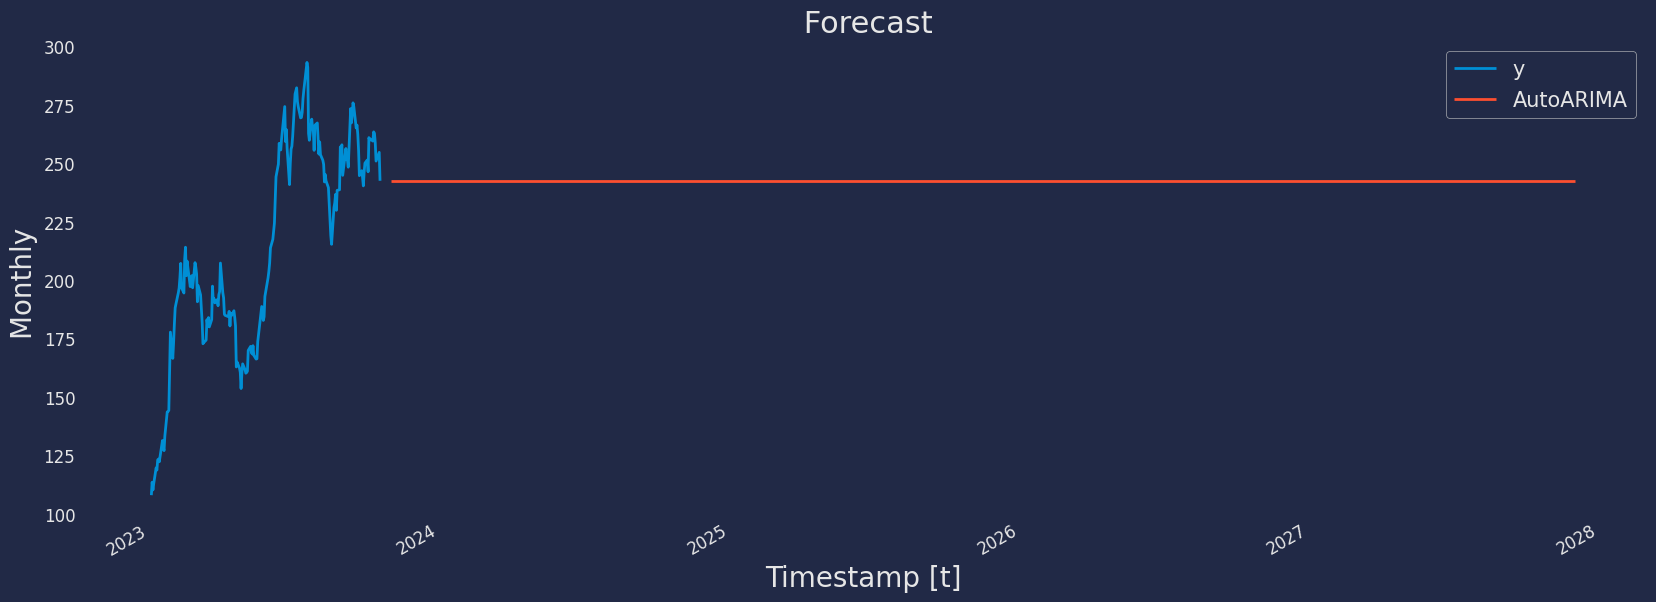

In [371]:
# Plotting forecast
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

The forecasting is pretty poor on this model. Perharp it didnt capture seasonality and trends well, or maybe the model is too simple that might need exogenous variables.

#### RSME for AutoARIMA

In [372]:
# prompt: Comute a RSME for the model above

from sklearn.metrics import mean_squared_error
Y_hat_df = Y_hat_df.dropna(subset=['y', 'AutoARIMA'])

rmse = np.sqrt(mean_squared_error(Y_hat_df['y'], Y_hat_df['AutoARIMA']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 26.31826377325131


## SARIMAX model

### Prep data

In [373]:
# Make a copy of Tesla dataframe
tesla_2 = tesla.copy()

if isinstance(tesla_2.columns, pd.MultiIndex):
    tesla_2.columns = ['_'.join(col).strip() for col in tesla_2.columns.values]

tesla_2 = tesla_2.reset_index()
tesla_2 = tesla_2.rename(columns={"Date": "ds", "Close_TSLA": "y"})

print(tesla_2.head())
print(tesla_2.info())

          ds           y
0 2023-01-03  108.099998
1 2023-01-04  113.639999
2 2023-01-05  110.339996
3 2023-01-06  113.059998
4 2023-01-09  119.769997
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      250 non-null    datetime64[ns]
 1   y       250 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB
None


### Train-Test Split

In [374]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

train_size = int(len(tesla_2) * 0.8)
Y_train_df, Y_test_df = tesla_2.iloc[:train_size], tesla_2.iloc[train_size:]
print(Y_train_df.shape, Y_test_df.shape)

#  Use Auto-ARIMA to Find Best SARIMA Parameters
auto_sarima = auto_arima(
    Y_train_df["y"], seasonal=True, m=12, stepwise=True, trace=True
)
print(auto_sarima.summary())  # Shows best (p,d,q)(P,D,Q,s)


(200, 2) (50, 2)
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1349.708, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1353.359, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1353.361, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1349.498, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1351.708, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1351.708, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1353.706, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1351.360, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1351.361, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1353.360, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 2.917 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -673.749
Date:                Thu, 27 Feb 2025   AIC                           1349.498
Time:                        21:29:16   BIC                           1352.791
Sample:                             0   HQIC                          1350.831
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        51.0838      3.910     13.066      0.000      43.42

### Fit Sarima

In [375]:
# Extract best parameters
best_p, best_d, best_q = auto_sarima.order
best_P, best_D, best_Q, best_s = auto_sarima.seasonal_order

# Fit SARIMA Model Using `statsmodels` SARIMAX
sarima_model = SARIMAX(
    Y_train_df["y"], order=(best_p, best_d, best_q),
    seasonal_order=(best_P, best_D, best_Q, best_s)
)
sarima_fit = sarima_model.fit()

# Print model summary
print(sarima_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -673.749
Date:                Thu, 27 Feb 2025   AIC                           1349.498
Time:                        21:29:16   BIC                           1352.791
Sample:                             0   HQIC                          1350.831
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        51.0838      3.910     13.066      0.000      43.421      58.746
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                18.23
Prob(Q):                              0.55   Pr

### Forecast

In [376]:
n_periods = len(Y_test_df)
forecast = sarima_fit.forecast(steps=n_periods)

# Store results in test dataframe
Y_test_df["SARIMA_Forecast"] = forecast.values

#  Display Forecast Results in Table
forecast_results = Y_test_df[["ds", "y", "SARIMA_Forecast"]].copy()


forecast_results.head()


<ipython-input-376-689d2d9d8ac2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test_df["SARIMA_Forecast"] = forecast.values


,ds,y,SARIMA_Forecast
200,2023-10-19,220.110001,242.679993
201,2023-10-20,211.990005,242.679993
202,2023-10-23,212.080002,242.679993
203,2023-10-24,216.520004,242.679993
204,2023-10-25,212.419998,242.679993


### Evaluate Model Performance


In [377]:
rmse = np.sqrt(mean_squared_error(Y_test_df["y"], Y_test_df["SARIMA_Forecast"]))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 19.23


### Plotting

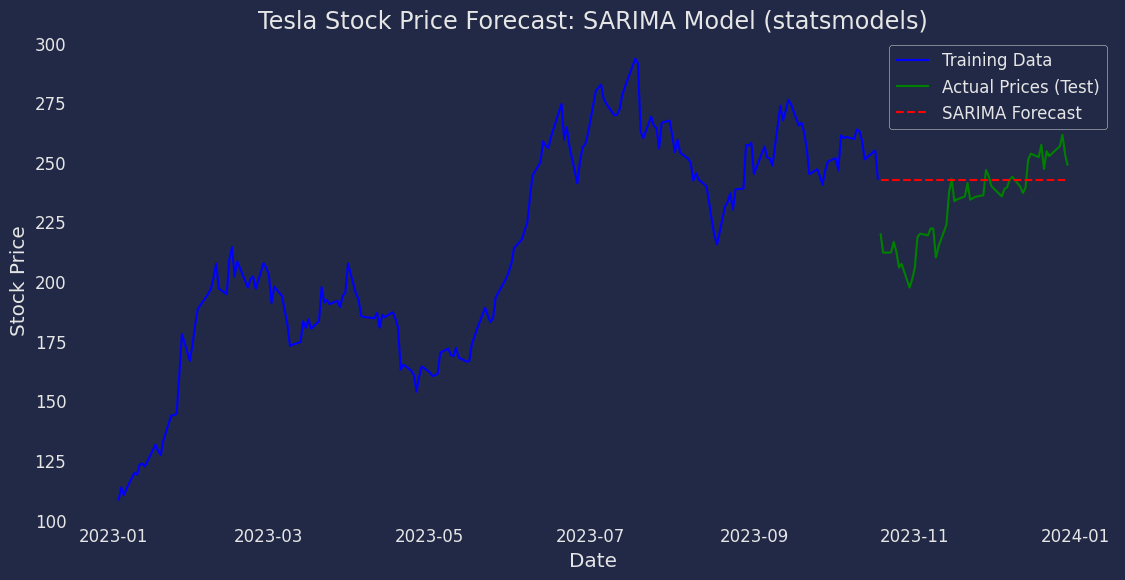

In [378]:
# Plot Actual vs Forecasted Prices
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(Y_train_df["ds"], Y_train_df["y"], label="Training Data", color="blue")
plt.plot(forecast_results["ds"], forecast_results["y"], label="Actual Prices (Test)", color="green")
plt.plot(forecast_results["ds"], forecast_results["SARIMA_Forecast"], label="SARIMA Forecast", linestyle="dashed", color="red")

plt.title("Tesla Stock Price Forecast: SARIMA Model (statsmodels)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()

# Multi Variate Time Series Forecasting

## AutoARIMA model

### Prep data for AutoArima model


In [379]:
# Combine Tesla, VIX, and QQQ into one DataFrame with multi-level columns
combined_df = pd.concat([tesla, vix, qqq], axis=1, keys=['TSLA', 'VIX', 'QQQ'])

# Flatten MultiIndex columns to remove hierarchy
combined_df.columns = ['_'.join(col).strip() for col in combined_df.columns]

# Merge GDP with combined_df using left join to keep stock data intact
final_df = combined_df.merge(gdp_df, left_index=True, right_index=True, how='left')

# Select specific columns and rename them
final_df = final_df[['TSLA_Close_TSLA', 'VIX_Close_^VIX', 'QQQ_Close_QQQ', 'GDP']]
final_df = final_df.rename(columns={
    'TSLA_Close_TSLA': 'Tesla_Price',
    'VIX_Close_^VIX': 'VIX',
    'QQQ_Close_QQQ': 'QQQ',
    'GDP': 'GDP'
})

# Viewing
print(final_df.head())
print(final_df.info())

            Tesla_Price        VIX         QQQ        GDP
Date                                                     
2023-01-03   108.099998  22.900000  261.113495  27164.359
2023-01-04   113.639999  22.010000  262.357422  27164.359
2023-01-05   110.339996  22.459999  258.250397  27164.359
2023-01-06   113.059998  21.129999  265.378510  27164.359
2023-01-09   119.769997  21.969999  267.096344  27164.359
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 to 2023-12-29
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tesla_Price  250 non-null    float64
 1   VIX          250 non-null    float64
 2   QQQ          250 non-null    float64
 3   GDP          250 non-null    float64
dtypes: float64(4)
memory usage: 9.8 KB
None


## VIF test


In [380]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'AARIMA_df' is your DataFrame
X = final_df[['Tesla_Price', 'VIX', 'QQQ', 'GDP']]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data


,feature,VIF
0,Tesla_Price,110.937661
1,VIX,116.692389
2,QQQ,886.640153
3,GDP,1114.559988


- All features have VIF > 10, indicating strong multicollinearity.
- QQQ and GDP have extreme VIF values (> 1000), meaning they are almost perfectly correlated with other features.


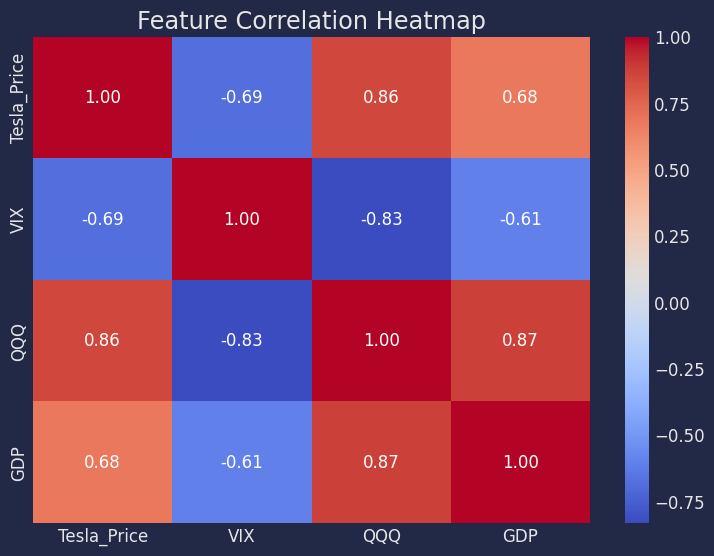

In [381]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(final_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


- QQQ and GDP are highly correlated (0.87):This suggests they are redundant and adding no extra information.Solution: Drop one of them (preferably GDP, since QQQ is a stock market ETF).
- Tesla_Price and QQQ are highly correlated (0.86)
- Since QQQ tracks the Nasdaq index (which includes Tesla), this is expected.
- VIX and QQQ are strongly negatively correlated (-0.83)

In [382]:
# Dropping GDP accordingly
final_df = final_df.drop('GDP', axis=1)
print(final_df.head())
print(final_df.info())

            Tesla_Price        VIX         QQQ
Date                                          
2023-01-03   108.099998  22.900000  261.113495
2023-01-04   113.639999  22.010000  262.357422
2023-01-05   110.339996  22.459999  258.250397
2023-01-06   113.059998  21.129999  265.378510
2023-01-09   119.769997  21.969999  267.096344
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 to 2023-12-29
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tesla_Price  250 non-null    float64
 1   VIX          250 non-null    float64
 2   QQQ          250 non-null    float64
dtypes: float64(3)
memory usage: 7.8 KB
None


### Auto ARIMA

#### Prepping data for AutoARIMA

In [383]:
final_df = final_df.reset_index()
final_df['unique_id'] = "1"
final_df = final_df.rename(columns={"Date": "ds", "Tesla_Price": "y"})
tesla_1["ds"] = pd.to_datetime(tesla_1["ds"])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_df['y'] = scaler.fit_transform(final_df[['y']])

print(final_df.head())
print(final_df.info())

          ds         y        VIX         QQQ unique_id
0 2023-01-03  0.000000  22.900000  261.113495         1
1 2023-01-04  0.029907  22.010000  262.357422         1
2 2023-01-05  0.012092  22.459999  258.250397         1
3 2023-01-06  0.026776  21.129999  265.378510         1
4 2023-01-09  0.062999  21.969999  267.096344         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         250 non-null    datetime64[ns]
 1   y          250 non-null    float64       
 2   VIX        250 non-null    float64       
 3   QQQ        250 non-null    float64       
 4   unique_id  250 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 9.9+ KB
None


#### Train-Split

In [384]:
train_size = int(len(final_df) * 0.8)
Y_train_df, Y_test_df = final_df.iloc[:train_size], final_df.iloc[train_size:]
print(Y_train_df.shape, Y_test_df.shape)

(200, 5) (50, 5)


#### Define StatsForecast AutoARIMA Model

In [385]:
model = AutoARIMA(season_length=12)

In [386]:
# Initialize StatsForecast with the model
sf = StatsForecast(
    models=[model],
    freq='D',  # Daily frequency
    n_jobs=1  # Number of jobs for parallel processing
)

#### Fit Model

In [387]:
sf.fit(df=Y_train_df)

StatsForecast(models=[AutoARIMA])

#### Forecast

In [388]:
# Define forecast horizon as the length of the test set
horizon = len(Y_test_df)

# Generate forecasts, providing exogenous features
forecasts = sf.predict(h=horizon, X_df=Y_test_df[['unique_id', 'ds', 'VIX', 'QQQ']])

# Merge forecasts with the test set
test_df = Y_test_df.merge(forecasts, on=['unique_id', 'ds'], how='left', validate='one_to_one')
test_df= test_df.dropna()

#### Plotting actual & forecast

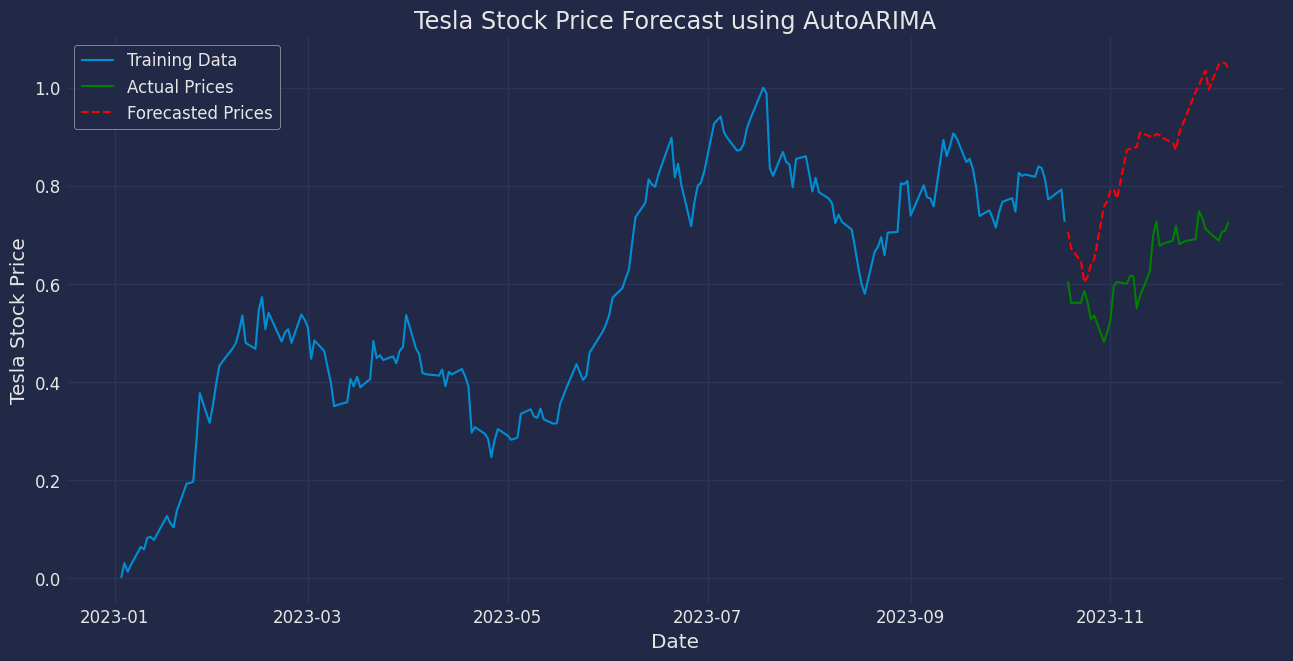

In [389]:
# Plot actual vs. forecasted values
plt.figure(figsize=(14, 7))
plt.plot(Y_train_df['ds'],Y_train_df['y'], label='Training Data')
plt.plot(test_df['ds'], test_df['y'], label='Actual Prices', color='green')
plt.plot(test_df['ds'], test_df['AutoARIMA'], label='Forecasted Prices', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Tesla Stock Price')
plt.title('Tesla Stock Price Forecast using AutoARIMA')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluation

In [390]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_df['y'], test_df['AutoARIMA']))

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 0.24


### Seasonal ARIMA

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-720.033, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-728.510, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-724.858, Time=1.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-724.857, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-728.720, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-726.510, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-726.510, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-724.513, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-726.858, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-726.857, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-724.855, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 5.671 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 365.360
Date:                Thu, 27 Feb 2025   AIC                           -728.720
Time:                        21:29:25   BIC                           -725.427
Sample:                             0   HQIC                          -727.387
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0015      0.000     13.066      0.000       0.00

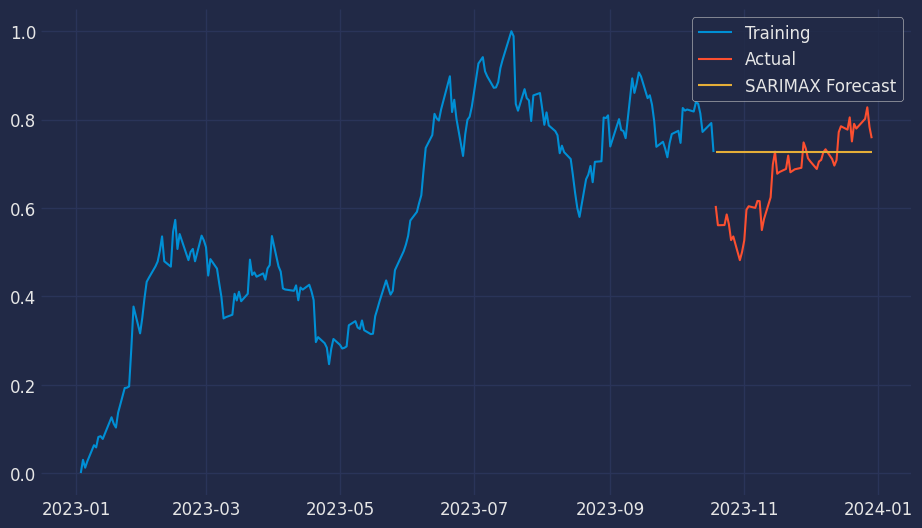

In [391]:
# Train-Test Split (if not already done)
train_size = int(len(final_df) * 0.8)
train_df, test_df = final_df.iloc[:train_size], final_df.iloc[train_size:]

# SARIMAX model fitting
# Find optimal (p, d, q) and (P, D, Q, s) orders using auto_arima
auto_sarima_model = auto_arima(
    train_df["y"],
    seasonal=True, m=12, # Assuming monthly seasonality (adjust if needed)
    stepwise=True, trace=True,
    error_action='ignore',  # ignore warnings
    suppress_warnings=True,  # suppress warnings
    max_p=7, max_d=2, max_q=7, # Adjust max values for p, d, q as needed
    max_P=4, max_D=2, max_Q=4 # Adjust max values for seasonal parameters as needed
)

# Print model summary
print(auto_sarima_model.summary())

# Extract best parameters
order = auto_sarima_model.order
seasonal_order = auto_sarima_model.seasonal_order

# Fit the SARIMAX model
sarima_model = SARIMAX(
    train_df["y"],
    order=order,
    seasonal_order=seasonal_order
)
sarima_fit = sarima_model.fit()

# Make predictions
n_periods = len(test_df)
forecast = sarima_fit.forecast(steps=n_periods)

# Evaluate
rmse = np.sqrt(mean_squared_error(test_df["y"], forecast))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_df['ds'], train_df['y'], label='Training')
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.plot(test_df['ds'], forecast, label='SARIMAX Forecast')
plt.legend()
plt.show()


# Conclusion



The AUTOARIMA model for multi-variate time series forecasting appears to produce the most accurate predictions based on visual analysis. However, the Root Mean Squared Error (RMSE) is 45.26, which is quite high compared to other models. This suggests that other models, like LSTM, might be better suited for forecasting stock prices.

# LSTM model

## Set up

In [392]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming 'final_df' is your DataFrame and 'y' is the target column
# Preprocess your data (normalize, scale, create sequences)
# Example:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_df['y'] = scaler.fit_transform(final_df[['y']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Example sequence length
X, y = create_sequences(final_df['y'].values, seq_length)

# Reshape data for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1) # Adjust epochs and batch_size


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3720
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2633
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1660
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0709
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0168
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0144
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0052
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

## Forecast

In [393]:
# Make predictions
y_pred = model.predict(X_test)

#Inverse transform the predictions if you scaled the data
y_pred = scaler.inverse_transform(y_pred)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


## Evaluate

In [394]:
# Evaluate the model
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.047


## Plotting

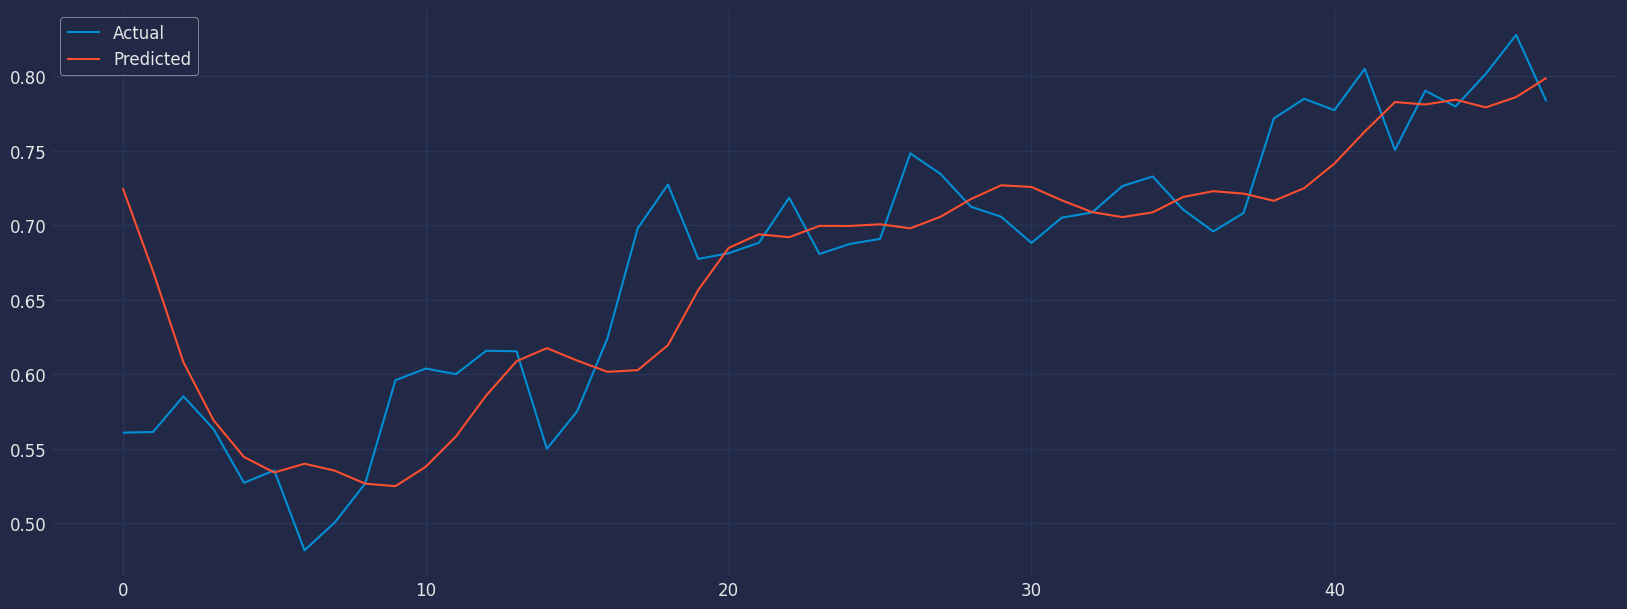

In [395]:
# Plot the results
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


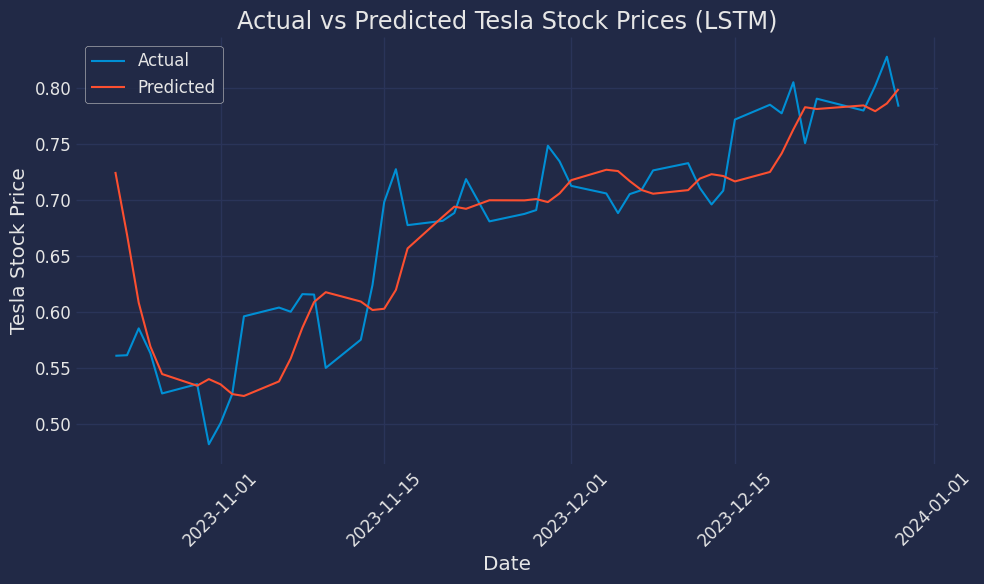

In [396]:
dates = final_df['ds'][train_size + seq_length + 1 : train_size + len(y_pred) + seq_length + 1]  # Adjust index accordingly

plt.figure(figsize=(10, 6))
plt.plot(dates, y_test, label='Actual')
plt.plot(dates, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Tesla Stock Price')
plt.title('Actual vs Predicted Tesla Stock Prices (LSTM)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


# Convert to HTML

In [416]:
!jupyter nbconvert --to html "/content/Final_Project.ipynb"

from google.colab import files
files.download("/content/Final_Project.html")

[NbConvertApp] Converting notebook /content/Final_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 1723258 bytes to /content/Final_Project.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>